<a href="https://colab.research.google.com/github/muilpop/pet_projects/blob/main/mobile_game_cookie_cats_ab_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Исследование результатов A/B-теста мобильной игры Cookie Cats

## Введение

**Описание проекта**

[Cookie Cats](https://www.youtube.com/watch?v=GaP5f0jVTWE) - чрезвычайно популярная мобильная игра-головоломка в стиле "соедини три", в которой игрок должен соединить плитки одного цвета, чтобы очистить игровое поле и выиграть уровень.

По мере прохождения игровых уровней игроки время от времени будут сталкиваться с воротами, которые вынуждают их ждать нетривиальное количество времени или совершать покупку в приложении, чтобы продвинуться дальше.

Помимо **стимулирования покупок** в приложении, эти ворота служат важной цели - предоставить игрокам **вынужденный перерыв** в игре, что, как мы надеемся, приведет к **увеличению и продлению удовольствия** игрока от игры.






**Цель исследования**


Но где должны быть расположены врата?

Изначально первые врата были установлены на 30-м уровне, но в этой тетради мы собираемся проанализировать AB-тест, в котором мы переместили первые врата в Cookie Cats с 30-го на 40-й уровень. В частности, мы рассмотрим влияние на удержание игроков.


**Описание переменных:**

* `userid` - уникальный номер, который идентифицирует каждого игрока.
* `version` - был ли игрок включен в контрольную группу (gate_30 - ворота на 30-м уровне) или в группу с перемещенными воротами (gate_40 - ворота на 40-м уровне).
* `sum_gamerounds` - количество игровых раундов, сыгранных игроком в течение первых 14 дней после установки.
* `retention_1` - возвращался ли игрок к игре через 1 день после установки?
* `retention_7` - возвращался ли игрок к игре через 7 дней после установки?

Когда игрок устанавливал игру, ему случайным образом назначались либо на `gate_30`, либо на `gate_40`.


## Обзор данных

In [1]:
#Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

In [2]:
# Подключение kaggle
! pip install kaggle
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

# Загрузка из соревнования:
# ! kaggle competitions download google-smartphone-decimeter-challenge -f baseline_locations_train.csv
# Загрузка обычного датасета:
! kaggle datasets download matinmahmoudi/rounds-and-retention

cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/matinmahmoudi/rounds-and-retention
License(s): apache-2.0
  0% 0.00/989k [00:00<?, ?B/s]
100% 989k/989k [00:00<00:00, 119MB/s]


In [3]:
# Распаковка и просмотр содержимого
! unzip rounds-and-retention.zip

Archive:  rounds-and-retention.zip
  inflating: Cookie_Cats_cleaned_v01.csv  
  inflating: Cookie_Cats_withNaNs_v01.csv  


In [4]:
# Загрузка датасета
csv_path = 'Cookie_Cats_cleaned_v01.csv'
df = pd.read_csv(csv_path)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


## Предобработка данных

In [6]:
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [7]:
df.reset_index(inplace=True)  # Перевод индекса в столбец


In [8]:
df.isna().sum() #сколько пропусков

,0
index,0
userid,0
version,0
sum_gamerounds,0
retention_1,0
retention_7,0


In [9]:
# # Количество в каждой группе
# df.groupby("version").apply(lambda x: x.index.nunique())
df['version'].value_counts()

,count
version,
gate_40,45489
gate_30,44700


Количество игроков в группах примерно одинаково

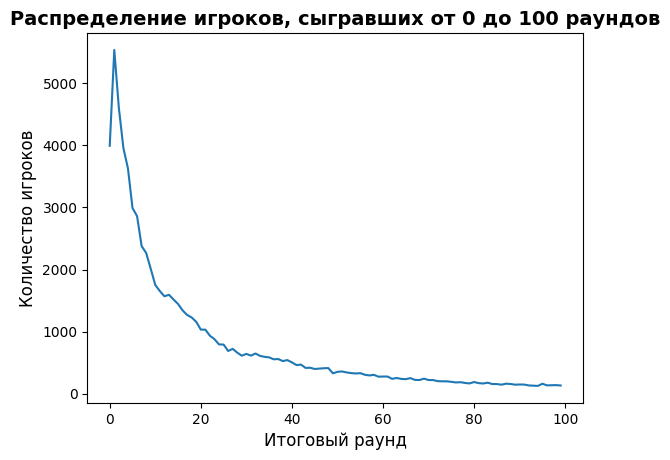

In [10]:
# Подсчет количества игроков для каждого количества раундов игры
plot_df = df.groupby("sum_gamerounds")['userid'].count()

# Построение графика распределения игроков, сыгравших от 0 до 100 раундов
ax = plot_df.head(100).plot()
plt.title("Распределение игроков, сыгравших от 0 до 100 раундов", fontweight="bold", size=14)
plt.xlabel("Итоговый раунд", size=12)
plt.ylabel("Количество игроков", size=12)
plt.show()

Некоторые игроки устанавливают игру, но не заходят в нее. Посмотрим сколько их.

In [11]:
df[df["sum_gamerounds"]== 0]["userid"].count()

3994

Основополагающей метрикой для данных мобильных игр является retention, т.е. какой процент игроков возращаются в игру.




In [12]:
df[['retention_1', 'retention_7']].mean()*100

,0
retention_1,44.520950
retention_7,18.606482


На 1 день в игру заходят чуть меньше половины игроков.
с 1-ого на 7 день удержание пользователя падаетс 44% до 18%.

In [13]:
#
df.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean", "sum_gamerounds":"sum"})

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,2344795
gate_40,45489,0.442283,0.182000,2333530


Небольшое снижение продолжительности удержания в течение 1 дня, когда ворота были переведены на 40-й уровень (44,2%), по сравнению с контрольной группой, когда они были на 30-м уровне (44,8%).

При этом на 7 день удержание также немного снизилось с 19% до 18,2%, после изменения постановки ворот с 30 на 40 уровень.

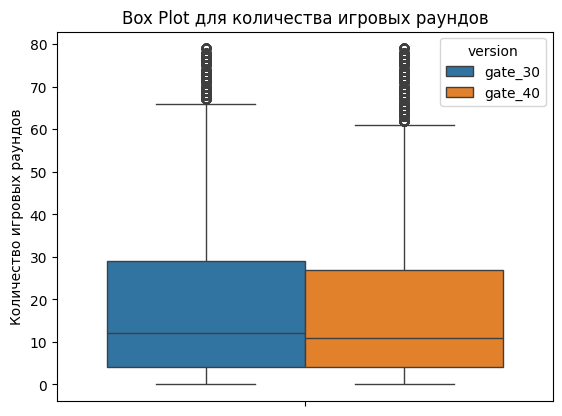

In [14]:
# Построение Box Plot для столбца 'sum_gamerounds'
plot_df =df[df['sum_gamerounds'] < 80]

sns.boxplot(data=plot_df, y="sum_gamerounds", hue='version')

# Настройка графика
plt.title("Box Plot для количества игровых раундов")
plt.ylabel("Количество игровых раундов")
plt.show()

## A/B Testing: Bootstrap

Группа А - ворота расположены на 30-м уровне

Группа В - ворота расположены на 40-м уровне


Среднее удержание вычисляется в каждой бутстреп-выборке, чтобы оценить распределение среднего удержания. Это дает более надежную статистическую оценку, чем использование одной выборки, так как учитываются возможные вариации в данных.

Суть метода в том, что  размер создаваемых выборок равен размеру исходных данных, поскольку берет повторно значения из набора данных. Таким образом мы получаем вариативность в данных, создавая случайные выборки.


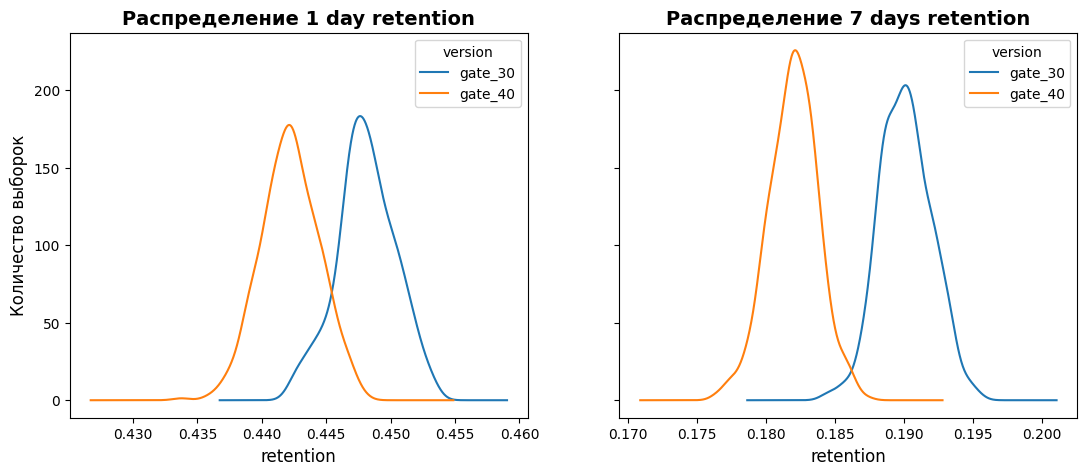

In [17]:
# A/B Testing: Bootstrapping

boot_1d = []
boot_7d = []

#Создаем 500 случайных выборок и считаем среднее по ним

for i in range(500):
    boot_mean_1 = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_mean_7 = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean_1)
    boot_7d.append(boot_mean_7)

# Трансформируем list в DataFrame
boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)

# Строим графики

fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,5))

boot_1d.plot.kde(ax=ax1)
ax1.set_xlabel("retention",size=12)
ax1.set_ylabel("Количество выборок",size=12)
ax1.set_title("Распределение 1 day retention", fontweight="bold",size=14)

boot_7d.plot.kde(ax=ax2)
ax2.set_xlabel("retention",size=12)
ax2.set_title("Распределение 7 days retention", fontweight="bold",size=14)
plt.show()

Визуально видим различия между двумя группами в обеих метриках. Расмотрим подробнее данное различие.

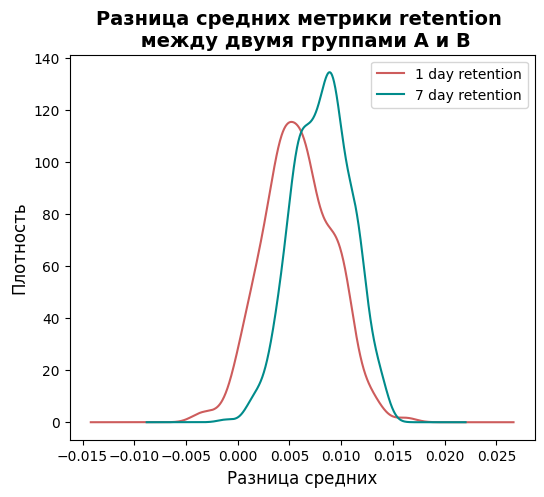

In [ ]:
# Разница средних
boot_1d['diff'] = boot_1d['gate_30'] - boot_1d['gate_40']
boot_7d['diff'] = boot_7d['gate_30'] -  boot_7d['gate_40']

# Визуализация
fig, (ax1) = plt.subplots(1,1, figsize=(6,5))

boot_1d['diff'].plot.kde(ax=ax1,c='#CD5C5C', label='1 day retention')
boot_7d['diff'].plot.kde(ax=ax1,c='#008B8B', label='7 day retention')
ax1.set_xlabel('Разница средних', size =12)
ax1.set_ylabel('Плотность', size =12)
ax1.set_title('Разница средних метрики retention \n между двумя группами А и В',
fontweight="bold", size=14 )
ax1.legend()
plt.show()


Большая часть распределения лежит далеко от 0. Причем выигрыш в сторону группы А, когда ворота на 30 уровне.

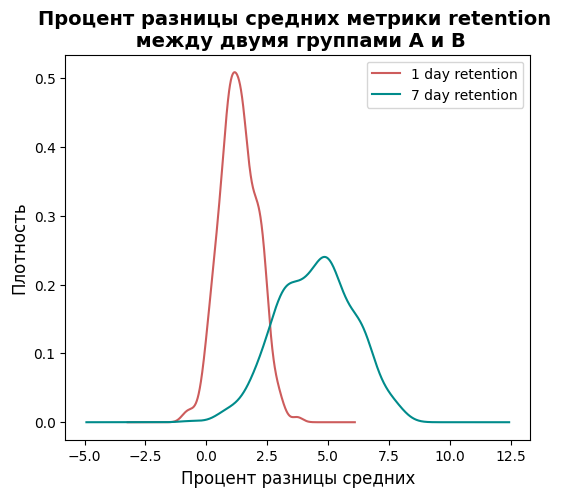

In [ ]:
# Разница средних
boot_1d['diff_percent'] = ( boot_1d['gate_30']- boot_1d['gate_40'] )/ boot_1d['gate_40'] * 100
boot_7d['diff_percent'] = ( boot_7d['gate_30']- boot_7d['gate_40'] )/boot_7d['gate_40'] * 100

# Визуализация
fig, (ax1) = plt.subplots(1,1, figsize=(6,5))

boot_1d['diff_percent'].plot.kde(ax=ax1,c='#CD5C5C', label='1 day retention')
boot_7d['diff_percent'].plot.kde(ax=ax1,c='#008B8B', label='7 day retention')
ax1.set_xlabel('Процент разницы средних', size =12)
ax1.set_ylabel('Плотность', size =12)
ax1.set_title('Процент разницы средних метрики retention \n между двумя группами А и В',
fontweight="bold", size=14 )
ax1.legend()
plt.show()



Вероятно постановка ворот на 40 уровень ухудшает метрику 1 day retention примерно на  1-2%, а метрику 7 day retention примерно на 5%.

In [ ]:
# Вероятность, что разница больше 0:
prob_1 = (boot_1d['diff_percent']>0).sum()/len(boot_1d['diff_percent'])

prob_7 = (boot_7d['diff_percent']>0).sum()/len(boot_7d['diff_percent'])

print(f"Вероятность что 1-day retention лучше когда ворота на 30 уровне: {round(prob_1,2)*100}% \
      \nВероятность что 7-day retention лучше когда ворота на 30 уровне: {(prob_7)*100}% ")


Вероятность что 1-day retention лучше когда ворота на 30 уровне: 97.0%       
Вероятность что 7-day retention лучше когда ворота на 30 уровне: 99.8% 


Чем ближе вероятность к 100%, тем более уверены в налчии различий.


Подводя итог, ворота необходимо оставить на 30 уровне, поскольку при постановки ворот на 40 уровень, метрики значимо ухудшаются. В особенности сильно ухудшается метрика 7 days retention.